In [1]:
%matplotlib inline

# Introduction

The goal of this notebook is to obtain a dataframe like the one below, with the x, y, z values of the left, right, upper, and lower lip positions and compute the following data based on the provided inputs

### Kinematics

IN WHICH DIRECTION? CURRENTLY ONLY VERTICAL 
Average speed for position direction for a given repetition (mouth opening, or spreading outward or inward)
Average speed for negative direction for a given repetition (mouth closing, or mouth returning to the rest position)
Average speed for position direction for a given task (meaning averaging over number of repetitions)
Average speed for negative direction for a given task (meaning averaging over number of repetitions)

### Range of Motion
Average Max vertical Distance for a given repetition of a task 
Average Max vertical Distance for a given task (meaning averaging over number of repetitions)
Average Min vertival Distance for a given task
Average vertical range of motion (Max - Min)

Average Max horizontal Distance for a given repetition of a task 
Average Max horizontal Distance for a given task (meaning averaging over number of repetitions)
Average Min horizontal Distance for a given task
Average horizontal range of motion (Max - Min)

### Symmetry 
Area of the triangle formed by left, top and bottom corners of the mouth 
Area of the right triangle formed by right, top and bottom corners of the mouth  
ratio of the two triangles 



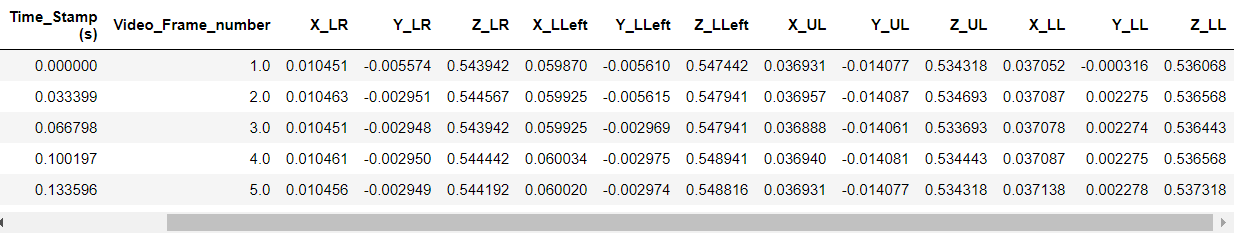

In [2]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from cv2 import VideoWriter, VideoWriter_fourcc
import pandas as pd
import torch
from scipy import signal, ndimage, spatial
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter
import math 

### Defining Functions to be used in the analysis sections

In [3]:
def cleaning_wave_df(DF):
    # dropping columns with no value
    #DF = DF.dropna(axis =1) 
    # dropping wave id column
    DF = DF.drop(columns = 2, axis =1)
    # name the first sensor columns 
    cols_0={0: "Time", 1: "FrameID", 3: "SensorID", 4: "Sensor_1Status", 5: "X_Nose", 6: "Y_Nose", 7:"Z_Nose"}
    DF = DF.rename(columns=cols_0, errors="raise")
    DF = DF.drop(columns = [8,9,10, 11], axis =1)
    
    DF = DF.drop(columns = [12,13,14,15,16,17,18,19,20], axis =1)
    cols_1={21: "SensorID", 22: "Sensor_2Status", 23: "X_LLeft", 24: "Y_LLeft", 25:"Z_LLeft"}
    DF = DF.rename(columns=cols_1, errors="raise")
    
    DF = DF.drop(columns = [26,27,28,29], axis =1)
    cols_2={30: "SensorID", 31: "Sensor_3Status", 32: "X_LR", 33: "Y_LR", 34:"Z_LR"}
    DF = DF.rename(columns=cols_2, errors="raise")
    
    DF = DF.drop(columns = [35,36,37,38], axis =1)
    cols_3={39: "SensorID", 40: "Sensor_4Status", 41: "X_UL", 42: "Y_UL", 43:"Z_UL"}
    DF = DF.rename(columns=cols_3, errors="raise")
    
    DF = DF.drop(columns = [44,45,46,47], axis =1)
    cols_4={48: "SensorID", 49: "Sensor_5Status", 50: "X_LL", 51: "Y_LL", 52:"Z_LL"}
    DF = DF.rename(columns=cols_4, errors="raise")
    
    DF = DF.drop(columns = [53,54,55,56], axis =1)
    cols_5={57: "SensorID", 58: "Sensor_6Status", 59: "X_JR", 60: "Y_JR", 61:"Z_JR"}
    DF = DF.rename(columns=cols_5, errors="raise")
    
    DF = DF.drop(columns = [62,63,64,65], axis =1)
    cols_6={66: "SensorID", 67: "Senson_7Status", 68: "X_JL", 69: "Y_JL", 70:"Z_JL"}
    DF = DF.rename(columns=cols_6, errors="raise")
    DF = DF.drop(columns = [71,72,73,74], axis =1)
    return DF



    

In [4]:
# cleaning video data 

def cleaning_video_df(DF):
    
    # choose the needed columns and convert the values to mm
    DF = DF[["BAG_Frame_number",'Time_Stamp (s)','Video_Frame_number',
             'landmark_48', 'landmark_48.1', 'landmark_48.2', 'landmark_54',
            'landmark_54.1', 'landmark_54.2', 'landmark_51', 'landmark_51.1',
            'landmark_51.2', 'landmark_57', 'landmark_57.1', 'landmark_57.2']]
  
    
    DF = DF.rename(columns={'Time_Stamp (s)': 'Time', "landmark_48": "X_LR", "landmark_48.1": "Y_LR",
                           "landmark_48.2": "Z_LR", "landmark_54": "X_LLeft",
                           "landmark_54.1": "Y_LLeft", "landmark_54.2": "Z_LLeft",
                           "landmark_51": "X_UL", "landmark_51.1": "Y_UL",
                           "landmark_51.2": "Z_UL", "landmark_57": "X_LL", "landmark_57.1": "Y_LL",
                           "landmark_57.2": "Z_LL"})
    
    DF = DF.astype({ "X_LR": np.double, "Y_LR": np.double,"Z_LR": np.double, "X_LLeft": np.double,
                            "Y_LLeft": np.double, "Z_LLeft": np.double, "X_UL": np.double,  "Y_UL": np.double,
                            "Z_UL": np.double,  "X_LL": np.double,  "Y_LL": np.double, "Z_LL": np.double})
    
    # conver the values from m to mm
    DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]] =  DF[["X_LR", "Y_LR","Z_LR", "X_LLeft", "Y_LLeft", "Z_LLeft", "X_UL",  "Y_UL","Z_UL",  "X_LL", 
       "Y_LL", "Z_LL"]]*1000
    return DF



Caculating all the line segments between any given two corners

In [5]:
def lipCornerDist(DF):
    
    # Assumes columns are named in a particular way 
    
    DF['Horiz_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LR)**2 + (row.Y_LLeft - row.Y_LR)**2
                                                                  + (row.Z_LLeft - row.Z_LR)**2), axis = 1) 
    DF['Vert_Lip_Motion'] = DF.apply(lambda row: math.sqrt((row.X_UL - row.X_LL)**2 + (row.Y_UL - row.Y_LL)**2 +
                                                                 (row.Z_UL - row.Z_LL)**2), axis = 1) 
    
    DF["DownToLeft"] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_LL)**2 + (row.Y_LLeft - row.Y_LL)**2
                                                                      + (row.Z_LLeft - row.Z_LL)**2), axis = 1)
    
    DF["UpToLeft"] = DF.apply(lambda row: math.sqrt((row.X_LLeft - row.X_UL)**2 + (row.Y_LLeft - row.Y_UL)**2
                                                                      + (row.Z_LLeft - row.Z_UL)**2), axis = 1)
    
    DF["DownToRight"] = DF.apply(lambda row: math.sqrt((row.X_LR - row.X_LL)**2 + (row.Y_LR - row.Y_LL)**2 +
                                                                 (row.Z_LR - row.Z_LL)**2), axis = 1) 
    
    DF["UpToRight"] = DF.apply(lambda row: math.sqrt((row.X_LR - row.X_UL)**2 + (row.Y_LR - row.Y_UL)**2 +
                                                                 (row.Z_LR - row.Z_UL)**2), axis = 1) 
    return DF


def area_of_triangle(A,B,C):

    """
    computes the area of a triangle given by 3 points in 2d or 3d

    A, B and C must be numpy arrays

    it works with vectors A=[a1,a2,a3], B=[b1,b2,b3], c=[c1,c2,c3] or matrices

    A=[[a11,a12,a13],...[a1n,a2n,b3n]], B=[[b11,b12,b13],...[b1n,b2n,b3n]], C=[[c11,c12,c13],...[c1n,c2n,c3n]]

    """

    As = A.shape
    Bs = B.shape
    Cs = C.shape
   
    if len(As) == 1 :

        #we got vectors

        if (As[0]>3) or (Bs[0]>3) or (Cs[0]>3):

            raise Exception('coordinates can only be 2d or 3d')

            return None

    else:

        #check at least one of the dimensions is two or three
        if (As[0]==2) or (As[0]==3) or (As[1]==2) or (As[1]==3):

            #one of the dimensions of A is 2 or 3, now check that all the vectors have the same size
            if (As!=Bs) or (As!=Cs):

                raise Exception('vectors must be the same size')
                return None

            else:
                #move forward
                pass

        else:

            raise Exception('coordinates can only be 2d or 3d')

            return None

    #at this point we know that one of the dimensions has 2 or 3 elements we move forward assuming that
    #the user provided the vectors with the correct size
    #move all vectors to the same origin

    AB = B-A
    AC = C-A  

    if len(As) == 1 :

        #if only one vector the simply compute the norm of the cross product
        area = (1/2)*np.linalg.norm(np.cross(AB,AC))

    else:

        #if only multiple vectors compute the norm along the axis one
        area = (1/2)*np.linalg.norm(np.cross(AB,AC), axis = 1)   

    return area



def findPeakIndex(array, minThreshold = 50, widthapart = 50,  twosided = True):
    
    peaks, _ = signal.find_peaks(array, height= minThreshold, distance= widthapart)
    
    if twosided == True:
        peaks_neg, _ = signal.find_peaks(-array, height= minThreshold, distance= widthapart)
        peaks = np.concatenate((peaks, peaks_neg), axis=None)
        peaks = np.sort(peaks, axis=None)
    
    return peaks
        

def rom(array, splits):

    reps = np.array_split(array, splits)
    
    reps.pop(0)
    pos_reps = reps[::2]
    neg_reps = reps[1::2]
    
    reps_max_values = np.array([np.max(array) for array in pos_reps])
    reps_min_values = np.array([np.min(array) for array in neg_reps])
    
    
    ROM = reps_max_values - reps_min_values
    
    return ROM, reps_max_values, reps_min_values
    

    

#### Reading Data 

In [6]:
# Initialize the list to store the dfs for wave and video
# ALways read wave data first then the video data 

Tasks = ['REST', 'OPEN', 'SPREAD', 'OOEE', 'PA', 'BBP', 'TNG_PROTRUSION', 'TNG_LAT', 'TNG_NOSE']
Conditions = ['FAST', 'SLOW', 'DISOR', 'HOLD']

TASK_DFS_VIDEO_LIST = list()
TASK_DFS_WAVE_LIST = list()
DataList = [TASK_DFS_WAVE_LIST, TASK_DFS_VIDEO_LIST]

In [7]:
len(TASK_DFS_VIDEO_LIST)

0

In [8]:
# READING DATA      


for technology in DataList:
    
    if DataList.index(technology) == 0:
        path = r'C:\Users\jafarid\Documents\Code\ValidationStudy\RM_3_20191101\WAVE\RM_3_20191101'
        ext=('.tsv')
    else:    
        path = r'C:\Users\jafarid\Documents\Code\ValidationStudy\FacialTrackingProcessed'
        ext=('_Landmarks3D.csv')


    Files = os.listdir(path)           
    Files = [i for i in Files if i.endswith(ext)]
    Task = Tasks[1]

    for i in range(0, len(Files)):
        # choose which task to focus on 
        if Task in Files[i]:
            if DataList.index(technology) == 0:
                df = pd.read_csv(path+ "\\" + Files[i], delimiter='\t', skiprows=1,header=None)
                df = cleaning_wave_df(df)

            else: 
                df = pd.read_csv(path+ "\\" + Files[i])
                df =  df.drop([0]) 
                df = cleaning_video_df(df)

            df['PatientID'] = Files[i][:4]
            df['DataDATE'] = Files[i][5:13]
            df['Task'] = Task
            for condition in Conditions:
                if condition in Files[i]:
                    df['Condition'] = condition

                if 'Condition' not in df.columns:
                    df['Condition'] = 'NORMAL'

            try:
                # preprocessing, using the cubic interpolation to fill in the missing data 
                df = df.interpolate(method ='cubic', limit_direction ='forward') 
                df = lipCornerDist(df)



                left_area = area_of_triangle(df[["X_LLeft", "Y_LLeft", "Z_LLeft"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                               df[["X_LL", "Y_LL", "Z_LL"]].values)
                df['Area_Left'] = np.array(left_area)
                right_area = area_of_triangle(df[["X_LR", "Y_LR","Z_LR"]].values, df[["X_UL",  "Y_UL","Z_UL"]].values, 
                                                df[[ "X_LL", "Y_LL", "Z_LL"]].values)
                df['Area_Right'] =  np.array(right_area)        
                df["Area_Ratio"] = df.apply(lambda row: row.Area_Left/row.Area_Right, axis = 1)
                df['Vert_Lip_Motion']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
                df['Horiz_Lip_Motion']= gaussian_filter(df['Horiz_Lip_Motion'], sigma=7)
                df["Speed"] = gaussian_filter(np.gradient(df['Vert_Lip_Motion'], df["Time"]), 3)
                #df["Speed"]= gaussian_filter(df["Speed"], sigma=3)

            except:
                print(Files[i])

            if DataList.index(technology) == 0:
                TASK_DFS_WAVE_LIST.append(df)

            else:
                TASK_DFS_VIDEO_LIST.append(df)
   

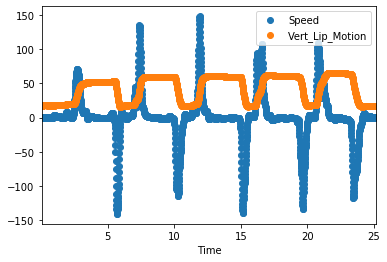

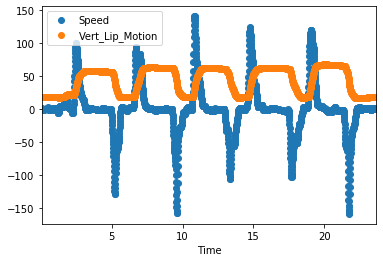

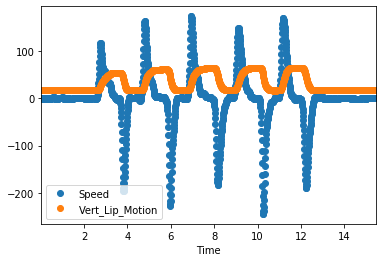

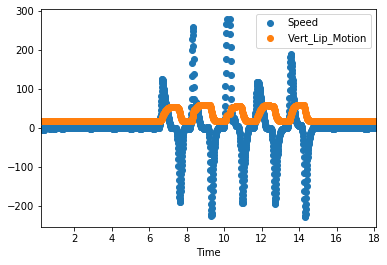

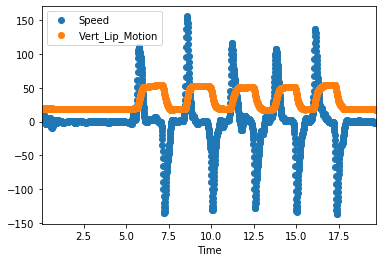

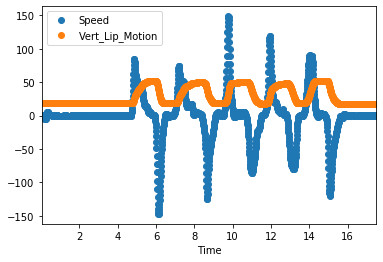

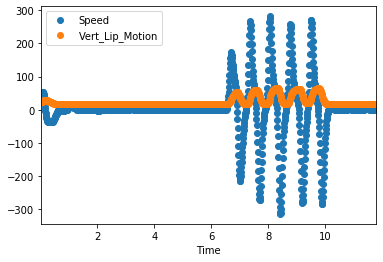

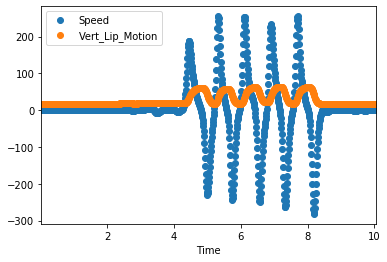

In [19]:
for df in TASK_DFS_WAVE_LIST:
    df.plot(x='Time', y=["Speed", 'Vert_Lip_Motion'], style='o')


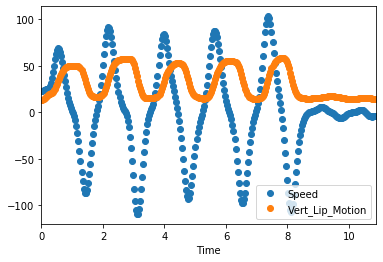

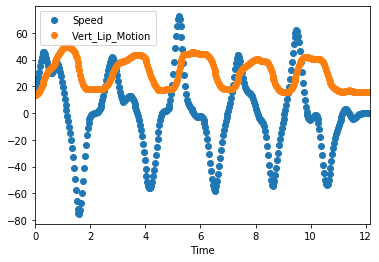

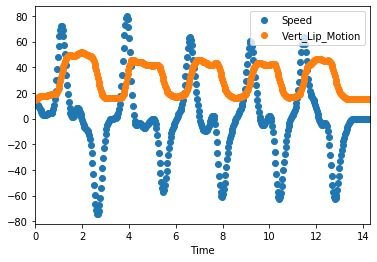

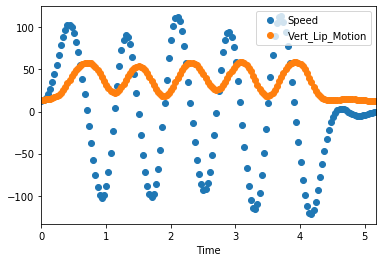

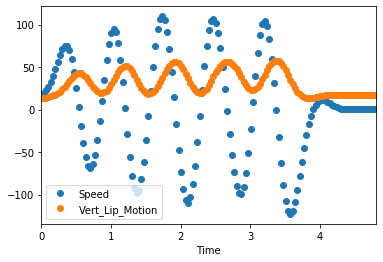

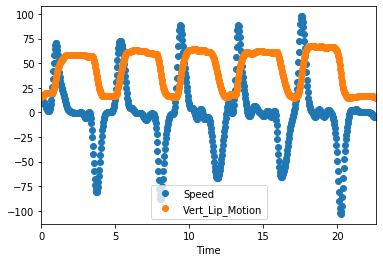

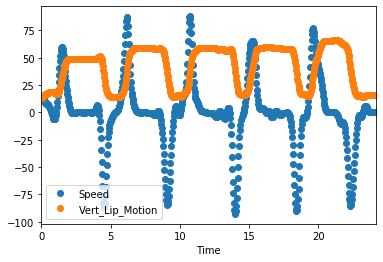

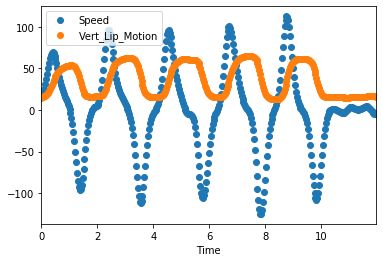

In [9]:
for df in TASK_DFS_VIDEO_LIST:
    df.plot(x='Time', y=["Speed", 'Vert_Lip_Motion'], style='o')


In [10]:
if 0: 
    for df in TASK_DFS_VIDEO_LIST:
        df['Vert_Lip_Motion_1']= gaussian_filter(df['Vert_Lip_Motion'], sigma=3)
        df.plot(x='Time', y=["Speed", 'Vert_Lip_Motion_1'], style='o')

In [11]:
TASK_DFS_WAVE_LIST[0].head()

,Time,FrameID,SensorID,Sensor_1Status,X_Nose,Y_Nose,Z_Nose,SensorID,Sensor_2Status,X_LLeft,...,Horiz_Lip_Motion,Vert_Lip_Motion,DownToLeft,UpToLeft,DownToRight,UpToRight,Area_Left,Area_Right,Area_Ratio,Speed
0,0.0347,0,0,55,-35.134182,-42.111202,-151.57620,2,55,-70.819328,...,66.251380,17.671610,35.562011,36.989320,35.576946,40.584137,309.896400,313.921508,0.987178,0.110607
1,0.0447,1,0,55,-35.171501,-42.129330,-151.57527,2,55,-70.853836,...,66.251101,17.671424,35.562517,37.017579,35.592002,40.571742,310.177036,314.292785,0.986905,0.139711
2,0.0547,2,0,55,-35.186321,-42.132694,-151.57590,2,55,-70.869865,...,66.250539,17.671441,35.593632,37.070818,35.571721,40.529443,310.283962,313.870369,0.988574,0.195557
3,0.0647,3,0,55,-35.206268,-42.150124,-151.58449,2,55,-70.851318,...,66.249687,17.672284,35.635937,37.091425,35.539308,40.509586,310.312073,313.256282,0.990601,0.273250
4,0.0747,4,0,55,-35.231308,-42.174553,-151.60271,2,55,-70.897232,...,66.248542,17.674563,35.649589,37.086321,35.499536,40.495961,310.286837,312.781330,0.992025,0.365316


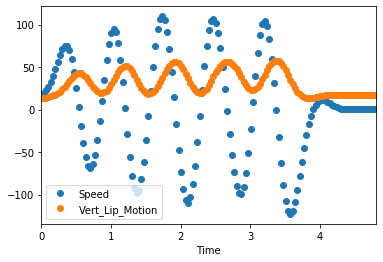

In [12]:
TASK_DFS_VIDEO_LIST[4].plot(x='Time', y=["Speed", 'Vert_Lip_Motion'], style='o')

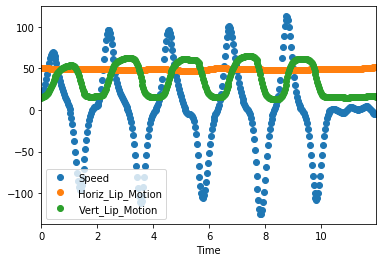

In [13]:
TASK_DFS_VIDEO_LIST[7].plot(x='Time', y=["Speed",'Horiz_Lip_Motion', 'Vert_Lip_Motion'], style='o')

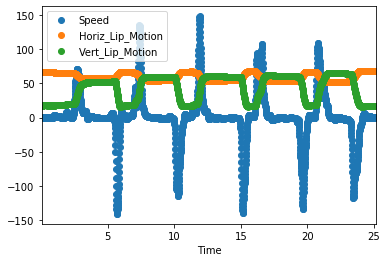

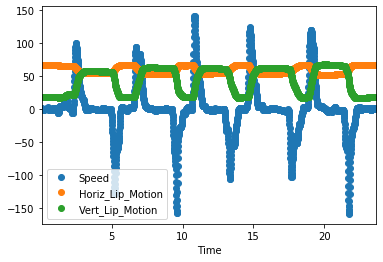

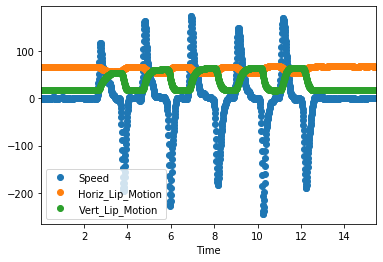

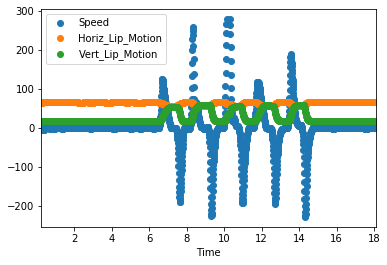

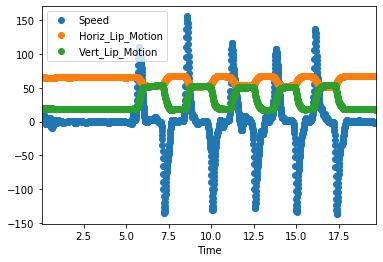

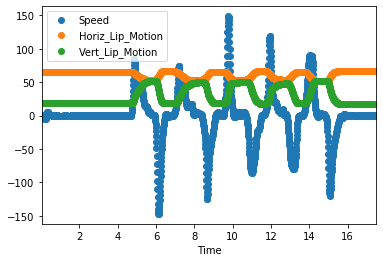

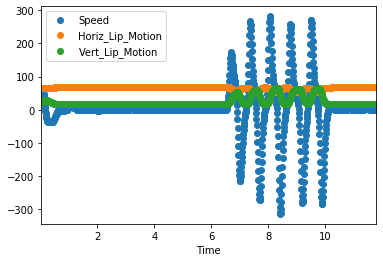

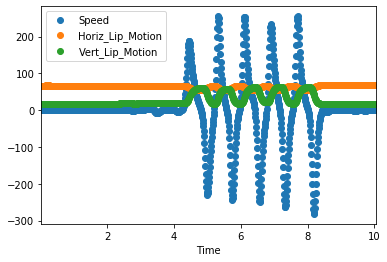

In [14]:
for df in TASK_DFS_WAVE_LIST:
    df.plot(x='Time', y=["Speed", 'Horiz_Lip_Motion', 'Vert_Lip_Motion'], style='o')

In [15]:
# if there are any missing values, which there shouldnt be, they need to get printed here
for i in range(0, len(TASK_DFS_WAVE_LIST)):
    df = TASK_DFS_WAVE_LIST[i]
    for j in df.isnull().sum():
        if j > 0:
            print(df.isnull().sum())
#print(TASK_DFS_WAVE_LIST[3]['Vert_Lip_Motion'].isnull().sum())
#print(TASK_DFS_WAVE_LIST[3]['X_LL'].isnull().sum())


In [16]:
TASK_DFS_VIDEO_LIST[3].isnull().sum()
#print(TASK_DFS_WAVE_LIST[3][['X_UL','X_LL','Y_UL','Y_LL','Z_UL','Z_LL','Vert_Lip_Motion']][600:650])

BAG_Frame_number      0
Time                  0
Video_Frame_number    0
X_LR                  0
Y_LR                  0
Z_LR                  0
X_LLeft               0
Y_LLeft               0
Z_LLeft               0
X_UL                  0
Y_UL                  0
Z_UL                  0
X_LL                  0
Y_LL                  0
Z_LL                  0
PatientID             0
DataDATE              0
Task                  0
Condition             0
Horiz_Lip_Motion      0
Vert_Lip_Motion       0
DownToLeft            0
UpToLeft              0
DownToRight           0
UpToRight             0
Area_Left             0
Area_Right            0
Area_Ratio            0
Speed                 0
dtype: int64

In [17]:
#TASK_DFS_VIDEO_LIST[3].head()

#### Kinematics

In [18]:

out = pd.DataFrame()

#result_w = pd.DataFrame()
result = pd.DataFrame()


for DF in TASK_DFS_WAVE_LIST:
    out = pd.DataFrame()
    speed = DF['Speed'].values


        #print(DF.head())
        #print(DF['Condition'][1])
        #print(DataList.index(df_list))
    peaks = findPeakIndex(speed, minThreshold = 50, widthapart = 50,  twosided = True)

       
    ROM_V, V_max, V_min = rom(DF['Vert_Lip_Motion'].values, peaks)

    avg_task_VROM = np.mean(ROM_V)
    avg_task_Vmax = np.mean(V_max)
    avg_task_Vmin = np.mean(V_min)
    print(DF['Condition'][1])
    print(ROM_V, V_max, V_min)
    out['Ver_Dist_Max_Wave'] = np.array(V_max)
    out['Ver_Dist_Min_Wave'] = np.array(V_min)
    out['ROM_Wave'] = np.array(ROM_V)

    out['PatientID'] = DF['PatientID'][1]
    out['DataDATE'] = DF['DataDATE'][1]
    out['Condition'] = DF['Condition'][1]
    out['Task'] = DF['Task'][1]

   # print(len(peaks))
    result = result.append(out, ignore_index = True) 



HOLD
[36.82355428 43.72983631 44.64556579 44.88654804 49.5088324 ] [53.01696736 60.00769879 60.88146067 62.20339956 65.69436901] [16.19341308 16.27786248 16.23589488 17.31685153 16.18553661]
HOLD
[39.84980769 45.42321034 45.26310319 45.78630922 51.1536663 ] [57.5585601  63.40193565 62.5499275  62.83238705 67.87678275] [17.70875241 17.97872531 17.28682431 17.04607783 16.72311645]
NORMAL
[36.41664888 43.47302174 46.44038121 47.73303654 47.59187071] [54.02776988 61.57929868 63.95570543 64.21458266 64.69984771] [17.611121   18.10627694 17.51532423 16.48154612 17.107977  ]
NORMAL
[35.79415243 41.24373105 38.97133887 40.24913318 43.24122665] [53.48407723 59.56161503 56.47470683 58.23840501 60.48157618] [17.6899248  18.31788398 17.50336796 17.98927183 17.24034953]
DISOR
[36.2669668  34.65597264 34.35294891 33.57329082 36.84637265] [53.89947883 53.12192448 50.99973392 51.43833158 54.68658192] [17.63251202 18.46595183 16.64678501 17.86504076 17.84020927]
DISOR
[33.82980235 31.9585905  33.116522

ValueError: operands could not be broadcast together with shapes (6,) (5,) 

In [ ]:
result_v = pd.DataFrame()

TASK_DFS_VIDEO_LIST = TASK_DFS_VIDEO_LIST.pop(4)

for DF in TASK_DFS_VIDEO_LIST:
    out = pd.DataFrame()
    speed = DF['Speed'].values

    peaks = findPeakIndex(speed, minThreshold = 5, widthapart = 5,  twosided = True)
    ROM_V, V_max, V_min = rom(DF['Vert_Lip_Motion'].values, peaks)

    
    print(DF['Condition'][1])
    print(ROM_V, V_max, V_min)
    out['Ver_Dist_Max_Video'] = np.array(V_max)
    out['Ver_Dist_Min_Video'] = np.array(V_min)
    out['ROM_Wave'] = np.array(ROM_V)

    out['PatientID'] = DF['PatientID'][1]
    out['DataDATE'] = DF['DataDATE'][1]
    out['Condition'] = DF['Condition'][1]
    out['Task'] = DF['Task'][1]
    
    print(len(peaks))
    result_v = result_v.append(out, ignore_index = True) 



In [ ]:
for DF in TASK_DFS_VIDEO_LIST:
    
    if result['Condition'] = DF['Condition'][0]
    speed = DF['Speed'].values

In [ ]:
for df_list in DataList:
    print(len(df_list))
    #print(DataList.index(df_list))
    

In [ ]:
DataList.index(TASK_DFS_VIDEO_LIST)

#### ROM

In [ ]:
DF = 
DF.plot(x='FrameID',y = ["Speed",'Horiz_Lip_Motion', 'Vert_Lip_Motion'])

In [ ]:


findPeakIndex(array, minThreshold = 50, widthapart = 50,  twosided = True)
# vertical ROM
vertical_openings = signal.medfilt(, 5)
ROM_V, V_max, V_min = rom(DF['Vert_Lip_Motion'], splits, max_threshold = 50, min_threshold=20,  kernel = 5)


print('average vertical opening distance: {}'.format(V_max))
print('average vertical closing distance: {}'.format(V_min))
print('average ROM vertical: {}'.format(ROM_V))
print()
#print('average horiz opening distance: {}'.format(avg_horiz_distance_max))
#print('average horiz closing distance: {}'.format(avg_horiz_distance_min))
#print('average ROM horiz: {}'.format(ROM_H))

#### Symmetry

In [ ]:
for DF in TASK_DFS_WAVE_LIST:
    print(DF.Condition[0])

In [ ]:
TASK_DFS_WAVE_LIST[1]['Horiz_Lip_Motion'].values

In [ ]:
print (len(TASK_DFS_WAVE_LIST))
print (len(TASK_DFS_VIDEO_LIST))

for i in TASK_DFS_WAVE_LIST:
    print (i.Condition[0])

print()
for i in TASK_DFS_VIDEO_LIST:
    print (i.Condition[1])

In [ ]:
DataList[1]